##### Jupyter Notebook, Step 3 - Feature Importance
- Use the results from step 2 to discuss feature importance in the dataset
- Considering these results, develop a strategy for building a final predictive model
- recommended approaches:
    - Use feature selection to reduce the dataset to a manageable size then use conventional methods
    - Use dimension reduction to reduce the dataset to a manageable size then use conventional methods
    - Use an iterative model training method to use the entire dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest,f_classif,SelectFromModel,SelectPercentile
                                      
from sklearn.metrics import (precision_score,accuracy_score,roc_auc_score,roc_curve,precision_recall_curve, 
                             recall_score,make_scorer,auc) 
                              
from sklearn.metrics import classification_report, precision_recall_curve,confusion_matrix
from sklearn.linear_model import LassoCV, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.utils import check_array
from scipy.stats import boxcox, skew
from tqdm import tqdm
import pickle

%matplotlib inline

ModuleNotFoundError: No module named 'tqdm'

In [2]:
class Read_pickled_madelon_Datasets(object):
   
    # Initializing object.
    def __init__(self):
       
        # Read pickled data from NB1.
        self.data_dir = '../dataNB1/'    

        self.read_all_data_from_files()
        
    def read_all_data_from_files(self):
        self.X_train_data_df_1 = pd.read_pickle(self.data_dir +'X_train_data_df_1.p')
        self.X_train_data_df_2 = pd.read_pickle(self.data_dir +'X_train_data_df_2.p')
        self.X_train_data_df_3 = pd.read_pickle(self.data_dir +'X_train_data_df_3.p')

        self.X_valid_data_df = pd.read_pickle(self.data_dir +'X_valid_data_df.p')
        
        self.y_train_data_1 = pd.read_pickle(self.data_dir + 'y_train_data_1.p')
        self.y_train_data_2 = pd.read_pickle(self.data_dir + 'y_train_data_2.p')
        self.y_train_data_3 = pd.read_pickle(self.data_dir + 'y_train_data_3.p')
        
        self.y_valid_data = pd.read_pickle(self.data_dir + 'y_valid_data.p')
        
    def get_X_train_data_sets(self):
        return(self.X_train_data_df_1, self.X_train_data_df_2, self.X_train_data_df_3)
    
    def get_X_valid_data(self):
        return(self.X_valid_data_df)
    

    def get_X_test_data(self):
        return(self.X_test_data_df)
       
    def get_y_train_data(self):        
        # y data should be a 1D array of labels. It is now read as a dataframe of 1 column with each
        # element as a list of one int.  We want it to be just an int not a list.
        self.y_train_data_1 = np.array([val[0] for val in self.y_train_data_1.values])
        self.y_train_data_2 = np.array([val[0] for val in self.y_train_data_2.values])
        self.y_train_data_3 = np.array([val[0] for val in self.y_train_data_3.values])
        
        return(self.y_train_data_1, self.y_train_data_2, self.y_train_data_3)

    def get_y_valid_data(self):        
        # y data should be a 1D array of labels. It is now read as a dataframe of 1 column with each
        # element as a list of one int.  We want it to be just an int not a list.
        self.y_valid_data = np.array([val[0] for val in self.y_valid_data.values])

        return(self.y_valid_data)


In [3]:
# Read in UCI Madelon Data. 
read_data = Read_pickled_madelon_Datasets()

In [4]:
# Read pickled X train data subsets, gathered from UCI data.
X_train_data_df_1, X_train_data_df_2, X_train_data_df_3 = read_data.get_X_train_data_sets()

# Read pickled y train data subsets, from Notebook1.                                                        
y_train_data_1, y_train_data_2, y_train_data_3 = read_data.get_y_train_data()

# Read pickled X validate data.
X_validate = read_data.get_X_valid_data()

# Read pickled y validate data.
y_validate = read_data.get_y_valid_data()

# Create a list of X train subsets.
X_train_subsets = [X_train_data_df_1, X_train_data_df_2, X_train_data_df_3]

# Create a list of y train subsets.
y_train_subsets = [y_train_data_1, y_train_data_2, y_train_data_3]


In [5]:
# Read pickled dataframes from feature selection NB2.
SKB_Results_for_all_sets_df = []
SP_Results_for_all_sets_df = []
SFMlasso_Results_for_all_sets_df = []
DT_feature_Subsets_Results_df = []

SKB_Results_for_all_sets_df.append(pd.read_pickle('../dataNB2/SKB_feature_Results_TS1_df.p'))
SP_Results_for_all_sets_df.append(pd.read_pickle('../dataNB2/SP_feature_Results_TS1_df.p'))
SFMlasso_Results_for_all_sets_df.append(pd.read_pickle('../dataNB2/Lasso_feature_Results_TS1_df.p'))    
DT_feature_Subsets_Results_df.append(pd.read_pickle('../dataNB2/DT_NE_feature_Results_TS1_df.p'))

SKB_Results_for_all_sets_df.append(pd.read_pickle('../dataNB2/SKB_feature_Results_TS2_df.p'))
SP_Results_for_all_sets_df.append(pd.read_pickle('../dataNB2/SP_feature_Results_TS2_df.p'))
SFMlasso_Results_for_all_sets_df.append(pd.read_pickle('../dataNB2/Lasso_feature_Results_TS2_df.p'))
DT_feature_Subsets_Results_df.append(pd.read_pickle('../dataNB2/DT_NE_feature_Results_TS2_df.p'))

SKB_Results_for_all_sets_df.append(pd.read_pickle('../dataNB2/SKB_feature_Results_TS3_df.p'))
SP_Results_for_all_sets_df.append(pd.read_pickle('../dataNB2/SP_feature_Results_TS3_df.p'))
SFMlasso_Results_for_all_sets_df.append(pd.read_pickle('../dataNB2/Lasso_feature_Results_TS3_df.p'))
DT_feature_Subsets_Results_df.append(pd.read_pickle('../dataNB2/DT_NE_feature_Results_TS3_df.p'))

In [6]:
# Dataset 1
SKB_feats1 = SKB_Results_for_all_sets_df[0]['feature']
SP_feats1 = SP_Results_for_all_sets_df[0]['feature']
Lasso_feats1 = SFMlasso_Results_for_all_sets_df[0]['feature']
DT_feats1 = DT_feature_Subsets_Results_df[0]['feature']

# Dataset 2
SKB_feats2 = SKB_Results_for_all_sets_df[1]['feature']
SP_feats2 = SP_Results_for_all_sets_df[1]['feature']
Lasso_feats2 = SFMlasso_Results_for_all_sets_df[1]['feature']
DT_feats2 = DT_feature_Subsets_Results_df[1]['feature']

# Dataset 3
SKB_feats3 = SKB_Results_for_all_sets_df[2]['feature']
SP_feats3 = SP_Results_for_all_sets_df[2]['feature']
#Lasso_feats3 = SFMlasso_Results_for_all_sets_df[2]['feature']
Lasso_feats3=[0]
DT_feats3 = DT_feature_Subsets_Results_df[2]['feature']

In [7]:
feats_union1 = np.union1d(
                 np.union1d(
                    np.union1d(
                        SKB_feats1, SP_feats1), 
                    Lasso_feats1), 
                DT_feats1)

feats_union2 = np.union1d(
                 np.union1d(
                    np.union1d(
                        SKB_feats2, SP_feats2), 
                    Lasso_feats2), 
                DT_feats2)

feats_union3 = np.union1d(
                 np.union1d(
                    np.union1d(
                        SKB_feats3, SP_feats3), 
                    Lasso_feats3), 
                DT_feats3)

In [8]:
# Now let's take a look at the the union of all the features selected by each subset, from all the 
# feature selection models used. Those are:
#
#     SelectKBest, Noise reduction using DecisionTreeRegressor, SelectPercentile, SeectFromModel: Lasso.

In [9]:
# This is the union of all the fea
feats_union1, len(feats_union1)

(array([ 17,  28,  32,  48,  55,  64,  66,  79,  99, 105, 110, 120, 128,
        138, 153, 178, 213, 236, 241, 281, 286, 296, 318, 326, 335, 336,
        338, 347, 357, 378, 379, 390, 430, 433, 442, 451, 453, 455, 472,
        475, 493, 497]), 42)

In [10]:
feats_union2, len(feats_union2)

(array([ 28,  48,  64,  71, 105, 108, 128, 153, 226, 241, 250, 253, 255,
        281, 318, 336, 338, 378, 386, 390, 413, 420, 433, 434, 435, 442,
        448, 451, 453, 455, 472, 475, 486, 493, 496]), 35)

In [11]:
feats_union3, len(feats_union3)

(array([  0,  21,  28,  48,  64, 105, 128, 135, 151, 153, 196, 211, 241,
        243, 249, 263, 281, 318, 336, 338, 340, 353, 378, 381, 422, 425,
        429, 433, 436, 442, 443, 447, 451, 453, 455, 472, 475, 478, 493]), 39)

In [12]:
# Now let's look at the common selected features between all 4 methods.
# Features from the union of features selected by all models, in all datasets.
features_selected = np.intersect1d(feats_union1, np.intersect1d(feats_union2, feats_union3)) 
features_selected, len(features_selected)

(array([ 28,  48,  64, 105, 128, 153, 241, 281, 318, 336, 338, 378, 433,
        442, 451, 453, 455, 472, 475, 493]), 20)

In [13]:
#******** Let's now take data only from the selected features, for each dataset and the X validate data. *********

In [14]:
# X training datasets.
X_train_sel_feats_subsets_df = []
for X_subset in X_train_subsets:    
    X_train_sel_feats_subsets_df.append(X_subset.iloc[:, features_selected])

# X validate data.
X_validate_sel_feats = X_validate[features_selected]


In [16]:
# Pickle the datasets, with only the final 19 features selected.
X_train_sel_feats_subsets_df[0].to_pickle('../dataNB3/X_train_sel_feats_subsets_df1.p')
X_train_sel_feats_subsets_df[1].to_pickle('../dataNB3/X_train_sel_feats_subsets_df2.p')
X_train_sel_feats_subsets_df[2].to_pickle('../dataNB3/X_train_sel_feats_subsets_df3.p')

X_validate_sel_feats.to_pickle('../dataNB3/X_test_sel_feats_df.p')

In [15]:
X_train_sel_feats_subsets_df[0].shape, X_train_sel_feats_subsets_df[1].shape, X_train_sel_feats_subsets_df[2].shape, X_validate_sel_feats.shape 

((200, 20), (200, 20), (200, 20), (600, 20))

In [41]:
# Deskew data.
def deskew(df):
    X_bc = pd.DataFrame()
    for col in df.columns:
        box_cox_trans, lmbda = boxcox(df[col])
        X_bc[col] = pd.Series(box_cox_trans)
    
    return(X_bc)

In [93]:
# Let's try to do some more EDA on the 20 features to see if we can find the 5 features.

In [251]:
lasso = Lasso(alpha=1.0)
lasso.fit(X_train_sel_feats_subsets_df[0], y_train_subsets[0])


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

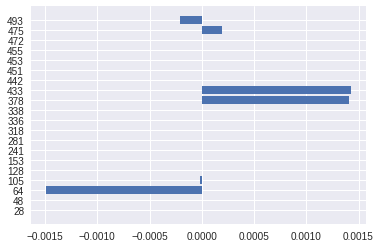

In [257]:
plt.barh(range(len(lasso.coef_)), lasso.coef_)
plt.yticks(range(len(lasso.coef_)), features_selected)
plt.show()

In [ ]:
# We clearly see here that there are 5 informative features.
# [ 64, 378, 433, 475, 493]

In [258]:
# Select the top 5 features since we know Madelon has 5 informative features.
features_selected_lasso = features_selected[abs(lasso.coef_) > 1e-4]
features_selected_lasso

array([ 64, 378, 433, 475, 493])

In [56]:
# X training datasets.
X_train_sel_feats_subsets_df = []
for X_subset in X_train_subsets:    
    X_train_sel_feats_subsets_df.append(X_subset.iloc[:, features_selected])

# X validate data.
X_validate_sel_feats = X_validate[features_selected]

In [58]:
# Scale and normalize the datasets.
for i in range(3):    
    ss = StandardScaler()    
    data = X_train_sel_feats_subsets_df[i]
    X_train_sel_feats_subsets_df[i]= ss.fit_transform(data)

In [59]:
# Now, since the madelon data is know to have only 5 informative features, let's
# do PCA on these dimension reduced datasets. 

In [60]:
def plot_PCA_explained_var(exp_var, dataset_num):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(range(1, len(exp_var)+1), exp_var, lw=2)
    ax.scatter(range(1, len(exp_var)+1), exp_var, s=120)
    ax.set_title('Explained variance pct: dataset' + str(dataset_num), fontsize=14)
    ax.set_xlabel('Principal Component', fontsize=12)
    ax.set_ylabel('Variance Explained (%)', fontsize=12)
    
    plt.savefig('../imgNB3/PCA: dataset: ' + str(dataset_num))
    plt.show()

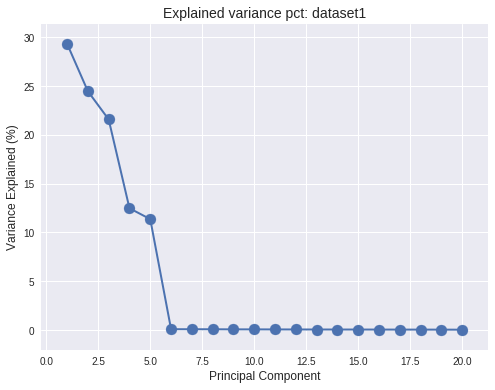

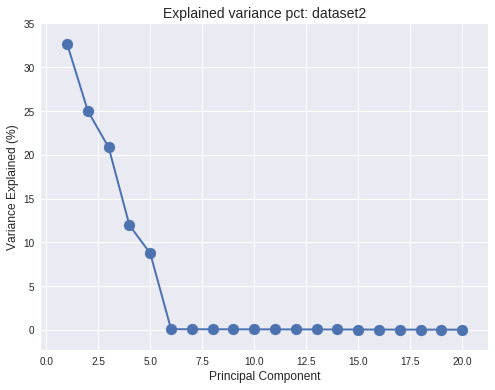

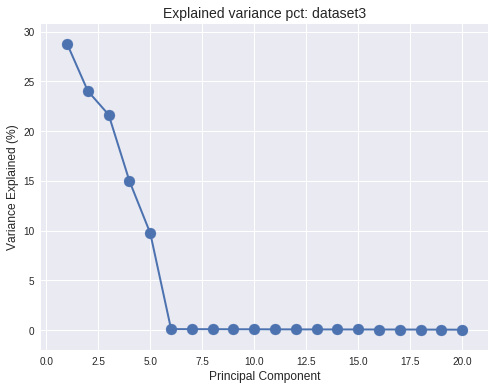

In [63]:
cnt = 0
for X_subset in X_train_sel_feats_subsets_df:
    cnt+=1
    pca = PCA()
    pca.fit(X_subset)
    exp_var = pca.explained_variance_ratio_
    
    plot_PCA_explained_var(exp_var*100, dataset_num = cnt)

In [22]:
# We clearly see here that there are 5 informative components of the datasets.

In [ ]:
# I will now do a gridsearch on all our models, to tune their hyper-parameters. 

# This will be done by doing the gridsearch on the PCA transformed data.

# Find the best model for all subsets for the following four model types:
# LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, SVC

In [64]:
# Log output
def log_output(dataset_name, model_name, sc_output, pipe):
    entry = {                
                'dataset'           :  dataset_name,
                'model'             :  model_name,
                'sc_tr_acc_score'   :  sc_output['train_score'],
                'sc_tst_acc_score'  :  sc_output['test_score'],
                'sc_recall'         :  sc_output['recall'],
                'sc_precision'      :  sc_output['precision'],
                'pipe_object'       :  pipe
            }
    return(entry)

In [65]:
def fit_and_score_pipeline(pipe, Xtrain, Xtest, ytrain, ytest, param_grid, target_names):
    
    gs = GridSearchCV(pipe, cv = 5, param_grid=param_grid)
  
    # Fit and score pipeline.
    gs.fit(Xtrain, ytrain) 
    
    # Mean accuracy score is returned.
    train_score = gs.score(Xtrain,ytrain)
    test_score = gs.score(Xtest,ytest)  
    y_pred = gs.predict(Xtest)
    
    # Calculate precision and recall.   
    recall = recall_score(ytest, y_pred)
    precision = precision_score(ytest, y_pred)
    
    output = {'train_score':train_score, 
              'test_score':test_score, 
              'recall':recall, 
              'precision':precision}
    
    #classification reports. 
    class_report_str = classification_report(ytest, y_pred, target_names=target_names)
    
    #confusion matrix.
    conf_matrix_raw = confusion_matrix(ytest, y_pred)
    
    return(output, class_report_str, conf_matrix_raw)


In [66]:
def execute_pipeline(model, dataTransformer, param_grid, Xtrain, ytrain, 
                     Xtest, ytest, target_names, model_results, model_name,
                     classification_rep, confusion_mtx):
   
    # Create a pipeline for the model.
    pipe = make_pipeline(StandardScaler(), 
                          dataTransformer,
                         model)
                                   
    # Fit, score and get model stats.                                           
    sc_output, cl_report_str, conf_mtx = fit_and_score_pipeline(pipe, 
                                                                Xtrain, Xtest, 
                                                                ytrain, ytest,
                                                                param_grid,
                                                                target_names=target_names)
       
    # Save classification report and confusion matrix, scaled data.
    key = model_name+str(tst_set+1)
    classification_rep[key] = cl_report_str
    key = model_name+str(tst_set+1)
    confusion_mtx[key] = conf_mtx
    
    # Log results.
    entry = log_output(dataset_name = 'Set_'+str(tst_set+1), 
                        model_name   = model_name, 
                        sc_output    = sc_output,
                        pipe         = pipe)

    # Append the output for this model to a list.
    model_results.append(entry)

In [67]:
# Setup the pipeline parameter grids.

In [68]:
param_grid_LR = {
                 'pca__n_components'           : [5],
                 'logisticregression__C'       : np.logspace(-3,3,7),
                 'logisticregression__penalty' : ['l1','l2']}

param_grid_DT = {
                 'pca__n_components'                   : [5],
                 'decisiontreeclassifier__max_depth'   : np.arange(1,8)}
                 
                 

param_grid_SVC = {
                  'pca__n_components'  : [5],
                  'svc__C'             : np.logspace(-3,3,7), 
                  'svc__gamma'         : np.logspace(-3,3,7)}
           

param_grid_KNN = {
                  'pca__n_components'                : [5],
                  'kneighborsclassifier__n_neighbors': np.arange(3,13,2),
                  'kneighborsclassifier__weights'    : ['uniform','distance']}

# Make a dictionary of models to run.
modelsToexecute_dict = {'LogisticRegression': [LogisticRegression(), param_grid_LR],
                        'SVC': [SVC(), param_grid_SVC],
                        'DecisionTree': [DecisionTreeClassifier(), param_grid_DT],
                        'KNN': [KNeighborsClassifier(), param_grid_KNN]}

In [69]:
# Save mean accuracy scores, classification reports and confusion matrix.
model_results = []
confusion_mtx = {}
classification_rep = {}
target_names=['class -1', 'class 1']

In [25]:
# Read in the entire pickled UCI training dataset.
X_train_data_df = pd.read_pickle('../dataNB1/' +'X_train_data_df.p')
y_train_data_df = pd.read_pickle('../dataNB1/' +'y_train_data.p')
y_train_data_arr = np.array([val[0] for val in y_train_data_df.values])

In [26]:
# Going to use all the 2000 rows of training data for x and y.
# X data is subsetted to include only te selected features.
Xtest =  X_validate[features_selected]
ytest =  y_validate
Xtrain = X_train_data_df[features_selected]
ytrain = y_train_data_arr

In [27]:
Xtest.shape, Xtrain.shape, ytest.shape, ytrain.shape

((600, 20), (2000, 20), (600,), (2000,))

In [28]:
dataTransformer = PCA()
num_datasets = 1
for tst_set in tqdm(range(num_datasets)):
    for model_name, params in modelsToexecute_dict.items():  
        
        model = params[0]
        param_grid = params[1]
                
        execute_pipeline(model, dataTransformer, param_grid, Xtrain, ytrain, 
                         Xtest, ytest, target_names, model_results, model_name,
                         classification_rep, confusion_mtx)

100%|██████████| 1/1 [00:54<00:00, 54.72s/it]


In [29]:
# Put all results in a dataframe.
model_results_df = pd.DataFrame(model_results)

# I am specifying the column arrangements.
model_results_df = model_results_df[['dataset', 'model', 'sc_tr_acc_score', 'sc_tst_acc_score',
                                     'sc_precision', 'sc_recall', 'pipe_object']]
                                     
model_results_df #PCA

dataset               model  sc_tr_acc_score  sc_tst_acc_score  \
0   Set_1  LogisticRegression            0.614          0.591667   
1   Set_1                 SVC            0.987          0.915000   
2   Set_1        DecisionTree            0.870          0.801667   
3   Set_1                 KNN            1.000          0.916667   

   sc_precision  sc_recall                                        pipe_object  
0      0.591362   0.593333  Pipeline(steps=[('standardscaler', StandardSca...  
1      0.902913   0.930000  Pipeline(steps=[('standardscaler', StandardSca...  
2      0.771772   0.856667  Pipeline(steps=[('standardscaler', StandardSca...  
3      0.905844   0.930000  Pipeline(steps=[('standardscaler', StandardSca...

In [30]:
svc_pipe = model_results_df.pipe_object[1]
svc_pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])>

In [31]:
knn_pipe = model_results_df.pipe_object[3]
knn_pipe.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('kneighborsclassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])>

In [32]:
# Display classification reports.
for k,v in classification_rep.items():
    print('*****  ' + k + '  Classification Report *****', '\n\n', v, '\n')

*****  LogisticRegression1  Classification Report ***** 

              precision    recall  f1-score   support

   class -1       0.59      0.59      0.59       300
    class 1       0.59      0.59      0.59       300

avg / total       0.59      0.59      0.59       600
 

*****  SVC1  Classification Report ***** 

              precision    recall  f1-score   support

   class -1       0.93      0.90      0.91       300
    class 1       0.90      0.93      0.92       300

avg / total       0.92      0.92      0.91       600
 

*****  DecisionTree1  Classification Report ***** 

              precision    recall  f1-score   support

   class -1       0.84      0.75      0.79       300
    class 1       0.77      0.86      0.81       300

avg / total       0.81      0.80      0.80       600
 

*****  KNN1  Classification Report ***** 

              precision    recall  f1-score   support

   class -1       0.93      0.90      0.92       300
    class 1       0.91      0.93      0.92

In [33]:
model_results_df.to_pickle('../dataNB3/FinalModels_GOOD_df.p')

In [ ]:
# Now let's try the Lasso selected features instead of using PCA and do a gridsearch.

In [269]:
# Going to use all the 2000 rows of training data for x and y.
# X data is subsetted to include only te selected features.
Xtest =  X_validate[features_selected_lasso]
ytest =  y_validate
Xtrain = X_train_data_df[features_selected_lasso]
ytrain = y_train_data_arr

In [270]:
#dataTransformer = PCA()
num_datasets = 1
for tst_set in tqdm(range(num_datasets)):
    for model_name, params in modelsToexecute_dict.items():  
        
        model = params[0]
        param_grid = params[1]
                
        execute_pipeline(model, dataTransformer, param_grid, Xtrain, ytrain, 
                         Xtest, ytest, target_names, model_results, model_name,
                         classification_rep, confusion_mtx)

100%|██████████| 1/1 [00:57<00:00, 57.96s/it]


In [271]:
# Put all results in a dataframe.
model_results_df = pd.DataFrame(model_results)

# I am specifying the column arrangements.
model_results_df = model_results_df[['dataset', 'model', 'sc_tr_acc_score', 'sc_tst_acc_score',
                                     'sc_precision', 'sc_recall', 'pipe_object']]
                                     
model_results_df 

# Lasso Results

dataset               model  sc_tr_acc_score  sc_tst_acc_score  \
0   Set_1  LogisticRegression           0.6200          0.596667   
1   Set_1                 SVC           0.9395          0.780000   
2   Set_1        DecisionTree           0.8140          0.688333   
3   Set_1                 KNN           1.0000          0.785000   

   sc_precision  sc_recall                                        pipe_object  
0      0.597315   0.593333  Pipeline(steps=[('standardscaler', StandardSca...  
1      0.769231   0.800000  Pipeline(steps=[('standardscaler', StandardSca...  
2      0.699647   0.660000  Pipeline(steps=[('standardscaler', StandardSca...  
3      0.768025   0.816667  Pipeline(steps=[('standardscaler', StandardSca...

In [ ]:
# Above is the Lasso selected features results. Its worse Then the PCA transformed data 
# results.